# ECE 271A HW3&4

**Import Libraries**

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fftpack import dct
from numpy.linalg import inv,det

**Load Data**

In [2]:
subsets = loadmat('./data/TrainingSamplesDCT_subsets_8.mat')
alpha = loadmat('./data/Alpha.mat')
p1 = loadmat('./data/Prior_1.mat')
p2 = loadmat('./data//Prior_2.mat')
zig_zag = np.genfromtxt('./data/zig_zag_pattern.txt', dtype=np.int64).flatten()
image = np.array(imageio.imread('./data/cheetah.bmp'), dtype=np.float64)/255
ground_truth = np.array(imageio.imread('./data/cheetah_mask.bmp'), dtype=np.float64)/255

In [3]:
print(subsets.keys())
print(alpha.keys())
print(p1.keys())
print(p2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'D1_BG', 'D2_BG', 'D3_BG', 'D4_BG', 'D1_FG', 'D2_FG', 'D3_FG', 'D4_FG'])
dict_keys(['__header__', '__version__', '__globals__', 'alpha'])
dict_keys(['__header__', '__version__', '__globals__', 'W0', 'mu0_FG', 'mu0_BG'])
dict_keys(['__header__', '__version__', '__globals__', 'W0', 'mu0_FG', 'mu0_BG'])


In [4]:
D1_BG = subsets['D1_BG']
D2_BG = subsets['D2_BG']
D3_BG = subsets['D3_BG']
D4_BG = subsets['D4_BG']
D1_FG = subsets['D1_FG']
D2_FG = subsets['D2_FG']
D3_FG = subsets['D3_FG']
D4_FG = subsets['D4_FG']

p1_w0 = p1['W0']
p1_mu0_FG = p1['mu0_FG']
p1_mu0_BG = p1['mu0_BG']
p2_w0 = p2['W0']
p2_mu0_FG = p2['mu0_FG']
p2_mu0_BG = p2['mu0_BG']
a = alpha['alpha']

BG = [D1_BG,D2_BG,D3_BG,D4_BG]
FG = [D1_FG,D2_FG,D3_FG,D4_FG]

In [5]:
dataset_num = len(FG)
alpha_num = a.shape[1]

**Helper Functions**

In [6]:
def zz_scan(block):
    scanned = np.zeros(64)
    for i in range(64):
        scanned[zig_zag[i]] = block[i]
    return scanned

In [7]:
def dct2d(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho').flatten()

In [8]:
def bdr(difference, inverse, determinant, prior):
    d = (difference.T.dot(inverse)).dot(difference)
    a = np.log((2*np.pi)**64*determinant) - 2*np.log(prior)
    return d + a

In [9]:
def ml_param(bg, fg):
    bg_cov = np.cov(bg.T) * (bg.shape[0]-1)/(bg.shape[0])
    fg_cov = np.cov(fg.T) * (fg.shape[0]-1)/(fg.shape[0])
    bg_mu = np.mean(bg, axis = 0)[:, np.newaxis]
    fg_mu = np.mean(fg, axis = 0)[:, np.newaxis]
    return bg_cov, fg_cov, bg_mu, fg_mu

# a)

## Bayesian Parameter Estimation

$\Sigma=\frac{1}{N}\sum_{i=1}^{N}(x_i-\frac{1}{N}\sum_{i=1}^{N}x_i)(x_i-\frac{1}{N}\sum_{i=1}^{N}x_i)^T$  
$\mu=\frac{1}{N}\sum_{i=1}^{N}(x_i)$

In [10]:
cov_BG = []
cov_FG = []
mu_BG = []
mu_FG = []
for i in range(dataset_num):
    bg_cov, fg_cov, bg_mu, fg_mu = ml_param(BG[i], FG[i])
    cov_BG.append(bg_cov)
    cov_FG.append(fg_cov)
    mu_BG.append(bg_mu)
    mu_FG.append(fg_mu)

$(\Sigma_{0})_{ii}=\alpha w_i$

In [11]:
cov_0_p1 = np.zeros((9,64,64))
for i in range(alpha_num):
    np.fill_diagonal(cov_0_p1[i], [a[0][i]*p1_w0])

$\mu_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}(\frac{1}{N}\sum_{i=1}^{N}x_i)+\frac{1}{N}\Sigma(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\mu_0$  
$\Sigma_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\frac{1}{N}\Sigma$

In [12]:
cov_1_FG = []
cov_1_BG = []
mu_1_FG = []
mu_1_BG = []
p_cheetah = []
p_grass = []
for i in range(dataset_num):
    mu1_FG = np.zeros((9,64,1))
    mu1_BG = np.zeros((9,64,1))
    cov1_FG = np.zeros((9,64,64))
    cov1_BG = np.zeros((9,64,64))
    prior_FG = FG[i].shape[0]/(FG[i].shape[0]+BG[i].shape[0])
    for j in range(alpha_num):
        cov0_FG = cov_0_p1[j]
        cov0_BG = cov_0_p1[j]
        
        weight1_FG = cov0_FG.dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))
        weight1_BG = cov0_BG.dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))
        weight2_FG = (cov_FG[i]/FG[i].shape[0]).dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))
        weight2_BG = (cov_BG[i]/BG[i].shape[0]).dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))
        
        mu1_FG[j] = mu1_FG[j] + weight1_FG.dot(mu_FG[i]) + weight2_FG.dot(p1_mu0_FG.T)
        mu1_BG[j] = mu1_BG[j] + weight1_BG.dot(mu_BG[i]) + weight2_BG.dot(p1_mu0_BG.T)
        cov1_FG[j] = cov1_FG[j] + (cov0_FG.dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))).dot(cov_FG[i]/FG[i].shape[0])
        cov1_BG[j] = cov1_BG[j] + (cov0_BG.dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))).dot(cov_BG[i]/BG[i].shape[0])
    
    cov_1_FG.append(cov1_FG)
    cov_1_BG.append(cov1_BG)
    mu_1_FG.append(mu1_FG)
    mu_1_BG.append(mu1_BG)
    p_cheetah.append(prior_FG)
    p_grass.append(1-prior_FG)

$P_{X|T}(x|D_1)=G(x,\mu_1,\Sigma_1+\Sigma)$

In [13]:
cov_1_FG_p = []
cov_1_BG_p = []
for i in range(dataset_num):
    cov_1_FG_p.append(cov_1_FG[i]+cov_FG[i])
    cov_1_BG_p.append(cov_1_BG[i]+cov_BG[i])

In [14]:
error_list = []
for m in range(dataset_num):
    for n in range(alpha_num):
        fg_inverse = inv(cov_1_FG_p[m][n])
        bg_inverse = inv(cov_1_BG_p[m][n])
        fg_determinant = det(cov_1_FG_p[m][n])
        bg_determinant = det(cov_1_BG_p[m][n])
        
        A = np.zeros(image.shape)
        for i in range(image.shape[0]-8):
            for j in range(image.shape[1]-8):
                block = image[i:i+8,j:j+8]
                transformed_block = dct(dct(block.T, norm='ortho').T, norm='ortho').flatten()
                transformed_block = zz_scan(transformed_block)

                fg = bdr(transformed_block[:,np.newaxis]-mu_1_FG[m][n], fg_inverse, fg_determinant, p_cheetah[m])
                bg = bdr(transformed_block[:,np.newaxis]-mu_1_BG[m][n], bg_inverse, bg_determinant, p_grass[m])
                A[i+4,j+4] = fg < bg
                
        error = A != ground_truth
        p_error = np.sum(error) / A.size
        error_list.append(p_error)
BPE_error_p1 = np.array(error_list).reshape((4,-1))

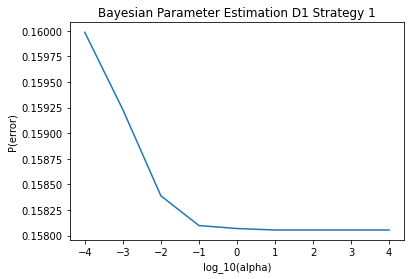

In [15]:
alpha_log = np.log10(a.flatten())
plt.plot(alpha_log, BPE_error_p1[0])
plt.title('Bayesian Parameter Estimation D1 Strategy 1')
plt.xlabel('log_10(alpha)')
plt.ylabel('P(error)')
plt.show()

We can observe from the graph that the probability of error decreases as $\alpha$ increases. The Bayesian Parameter Estimation as a function of $\alpha$ exhibits this behavior because $\alpha$ controls the weights given by strategy 1: smaller $\alpha$ diminishes the effect from $\Sigma_0$ and larger $\alpha$ amplifies the effect from $\hat{\mu}$. 

# b)

## Maximum Likelihood Estimation

In [16]:
error_list = []
for m in range(dataset_num):
    fg_inverse = inv(cov_FG[m])
    bg_inverse = inv(cov_BG[m])
    fg_determinant = det(cov_FG[m])
    bg_determinant = det(cov_BG[m])

    A = np.zeros(image.shape)
    for i in range(image.shape[0]-8):
        for j in range(image.shape[1]-8):
            block = image[i:i+8,j:j+8]
            transformed_block = dct(dct(block.T, norm='ortho').T, norm='ortho').flatten()
            transformed_block = zz_scan(transformed_block)

            fg = bdr(transformed_block[:,np.newaxis]-mu_FG[m], fg_inverse, fg_determinant, p_cheetah[m])
            bg = bdr(transformed_block[:,np.newaxis]-mu_BG[m], bg_inverse, bg_determinant, p_grass[m])
            A[i+4,j+4] = fg < bg
    error = A != ground_truth
    error_sum = np.sum(error)
    p_error = error_sum / A.size
    error_list.append(p_error)
MLE_error_p1 = np.array(error_list)

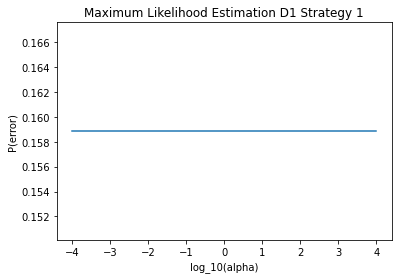

In [31]:
plt.plot(alpha_log, np.ones(9) * MLE_error_p1[0])
plt.title('Maximum Likelihood Estimation D1 Strategy 1')
plt.xlabel('log_10(alpha)')
plt.ylabel('P(error)')
plt.show()

Compared to the result of part a, Maximum Likelihood Estimation appears to be a constant straight line. The constant value seems to be the asymptote for the Bayesian Parameter Estimation. The estimate is based on all the values in the sample regardless of the $\alpha$ value and therefore is constant.

# c)

## Maximum A Posteriori Estimation

In [18]:
error_list = []
for m in range(dataset_num):
    for n in range(alpha_num):
        fg_inverse = inv(cov_FG[m])
        bg_inverse = inv(cov_BG[m])
        fg_determinant = det(cov_FG[m])
        bg_determinant = det(cov_BG[m])

        A = np.zeros(image.shape)
        for i in range(image.shape[0]-8):
            for j in range(image.shape[1]-8):
                block = image[i:i+8,j:j+8]
                transformed_block = dct(dct(block.T, norm='ortho').T, norm='ortho').flatten()
                transformed_block = zz_scan(transformed_block)

                fg = bdr(transformed_block[:,np.newaxis]-mu_1_FG[m][n], fg_inverse, fg_determinant, p_cheetah[m])
                bg = bdr(transformed_block[:,np.newaxis]-mu_1_BG[m][n], bg_inverse, bg_determinant, p_grass[m])
                A[i+4,j+4] = fg < bg
                
        error = A != ground_truth
        p_error = np.sum(error) / A.size
        error_list.append(p_error)
MAP_error_p1 = np.array(error_list).reshape((4,-1))

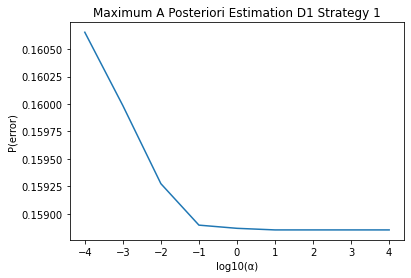

In [35]:
plt.plot(alpha_log, MAP_error_p1[0])
plt.title('Maximum A Posteriori Estimation D1 Strategy 1')
plt.xlabel('log10(\u03B1)')
plt.ylabel('P(error)')
plt.show()

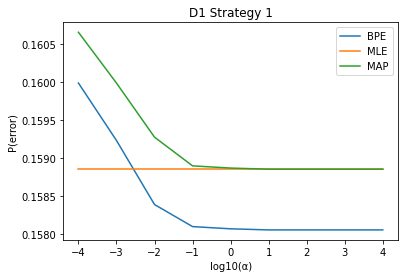

In [34]:
plt.plot(alpha_log, BPE_error_p1[0], label='BPE')
plt.plot(alpha_log, np.ones(9) * MLE_error_p1[0], label='MLE')
plt.plot(alpha_log, MAP_error_p1[0], label='MAP')
plt.title('D1 Strategy 1')
plt.legend(loc='upper right')
plt.xlabel('log10(\u03B1)')
plt.ylabel('P(error)')
plt.show()

Both Bayesian Parameter Estimation and Maximum A Posteriori Estimation have curves that decreases as $\alpha$ increases. We can also see that the Maximum A Posteriori Estimation converges to the Maximum Likelihood Estimation as $\alpha$ increases.
When $\alpha$ is smaller, the difference in error between Bayesian Parameter Estimation and Maximum A Posteriori Estimation vs. Maximum Likelihood Estimate is larger because the posterior covariance is smaller. Bayesian Parameter Estimation and Maximum A Posteriori Estimation shares the same posterior mean, and therefore the error is closer between them compared to error relative to the Maximum Likelihood Estimate when $\alpha$ is small. In contrast, when $\alpha$ is larger, the posterior mean would be closer to the Maximum Likelihood Estimate of the mean and therefore the Maximum A Posteriori Estimation converges to the Maximum Likelihood Estimation. We can also conclude that Bayesian Parameter Estimation yields slightly better result in this dataset because the sample is smaller compared to other datasets, showing the power of prior belief.

# d)

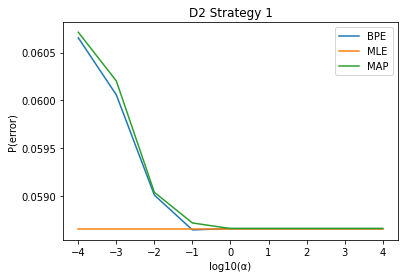

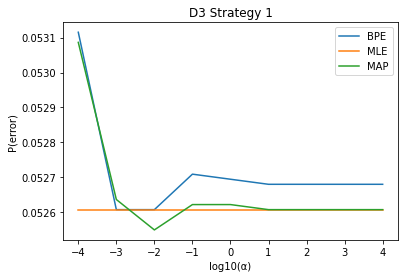

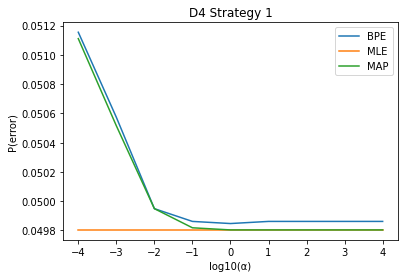

In [33]:
for i in range(1, dataset_num):
    plt.plot(alpha_log, BPE_error_p1[i], label='BPE')
    plt.plot(alpha_log, np.ones(9) * MLE_error_p1[i], label='MLE')
    plt.plot(alpha_log, MAP_error_p1[i], label='MAP')
    plt.title('D{} Strategy 1'.format(i+1))
    plt.legend(loc='upper right')
    plt.xlabel('log10(\u03B1)')
    plt.ylabel('P(error)')
    plt.show()

For all of the datasets, we can see that both Bayesian Parameter Estimation and Maximum A Posteriori Estimation converges to constant Maximum Likelihood Estimation from the reason explained from the previous part. Additionally, we can also observe that Maximum A Posteriori Estimation is more closely aligned with the probability of error from Maximum Likelihood Estimation relative to the Bayesian Parameter Estimation. There is also the trend that the average probability of error decreases as we go from dataset 1 to dataset 4 because the error goes down as the number of samples N increases. However, as the number of samples increase with each dataset, the performace of the Bayesian Parameter Estimation becomes generally worse than Maximum A Posteriori Estimation and Maximum Likelihood Estimation because prior belief isn't as important with a larger dataset as the posterior mean will generally converges to the Maximum Likelihood Estimate of the mean. 

# e)

In [23]:
cov_0_p2 = np.zeros((9,64,64))
for i in range(alpha_num):
    np.fill_diagonal(cov_0_p2[i], [a[0][i]*p2_w0])

In [24]:
cov_1_FG = []
cov_1_BG = []
mu_1_FG = []
mu_1_BG = []
for i in range(dataset_num):
    mu1_FG = np.zeros((9,64,1))
    mu1_BG = np.zeros((9,64,1))
    cov1_FG = np.zeros((9,64,64))
    cov1_BG = np.zeros((9,64,64))
    prior_FG = FG[i].shape[0]/(FG[i].shape[0]+BG[i].shape[0])
    for j in range(alpha_num):
        cov0_FG = cov_0_p2[j]
        cov0_BG = cov_0_p2[j]
        
        weight1_FG = cov0_FG.dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))
        weight1_BG = cov0_BG.dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))
        weight2_FG = (cov_FG[i]/FG[i].shape[0]).dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))
        weight2_BG = (cov_BG[i]/BG[i].shape[0]).dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))
        
        mu1_FG[j] = mu1_FG[j] + weight1_FG.dot(mu_FG[i]) + weight2_FG.dot(p2_mu0_FG.T)
        mu1_BG[j] = mu1_BG[j] + weight1_BG.dot(mu_BG[i]) + weight2_BG.dot(p2_mu0_BG.T)
        cov1_FG[j] = cov1_FG[j] + (cov0_FG.dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))).dot(cov_FG[i]/FG[i].shape[0])
        cov1_BG[j] = cov1_BG[j] + (cov0_BG.dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))).dot(cov_BG[i]/BG[i].shape[0])
    
    cov_1_FG.append(cov1_FG)
    cov_1_BG.append(cov1_BG)
    mu_1_FG.append(mu1_FG)
    mu_1_BG.append(mu1_BG)

In [25]:
cov_1_FG_p = []
cov_1_BG_p = []
for i in range(dataset_num):
    cov_1_FG_p.append(cov_1_FG[i]+cov_FG[i])
    cov_1_BG_p.append(cov_1_BG[i]+cov_BG[i])

In [26]:
error_list = []
for m in range(dataset_num):
    for n in range(alpha_num):
        fg_inverse = inv(cov_1_FG_p[m][n])
        bg_inverse = inv(cov_1_BG_p[m][n])
        fg_determinant = det(cov_1_FG_p[m][n])
        bg_determinant = det(cov_1_BG_p[m][n])
        
        A = np.zeros(image.shape)
        for i in range(image.shape[0]-8):
            for j in range(image.shape[1]-8):
                block = image[i:i+8,j:j+8]
                transformed_block = dct(dct(block.T, norm='ortho').T, norm='ortho').flatten()
                transformed_block = zz_scan(transformed_block)

                fg = bdr(transformed_block[:,np.newaxis]-mu_1_FG[m][n], fg_inverse, fg_determinant, p_cheetah[m])
                bg = bdr(transformed_block[:,np.newaxis]-mu_1_BG[m][n], bg_inverse, bg_determinant, p_grass[m])
                A[i+4,j+4] = fg < bg
                
        error = A != ground_truth
        p_error = np.sum(error) / A.size
        error_list.append(p_error)
BPE_error_p2 = np.array(error_list).reshape((4,-1))

In [27]:
error_list = []
for m in range(dataset_num):
    fg_inverse = inv(cov_FG[m])
    bg_inverse = inv(cov_BG[m])
    fg_determinant = det(cov_FG[m])
    bg_determinant = det(cov_BG[m])

    A = np.zeros(image.shape)
    for i in range(image.shape[0]-8):
        for j in range(image.shape[1]-8):
            block = image[i:i+8,j:j+8]
            transformed_block = dct(dct(block.T, norm='ortho').T, norm='ortho').flatten()
            transformed_block = zz_scan(transformed_block)

            fg = bdr(transformed_block[:,np.newaxis]-mu_FG[m], fg_inverse, fg_determinant, p_cheetah[m])
            bg = bdr(transformed_block[:,np.newaxis]-mu_BG[m], bg_inverse, bg_determinant, p_grass[m])
            A[i+4,j+4] = fg < bg
    error = A != ground_truth
    error_sum = np.sum(error)
    p_error = error_sum / A.size
    error_list.append(p_error)
MLE_error_p2 = np.array(error_list)

In [28]:
error_list = []
for m in range(dataset_num):
    for n in range(alpha_num):
        fg_inverse = inv(cov_FG[m])
        bg_inverse = inv(cov_BG[m])
        fg_determinant = det(cov_FG[m])
        bg_determinant = det(cov_BG[m])

        A = np.zeros(image.shape)
        for i in range(image.shape[0]-8):
            for j in range(image.shape[1]-8):
                block = image[i:i+8,j:j+8]
                transformed_block = dct(dct(block.T, norm='ortho').T, norm='ortho').flatten()
                transformed_block = zz_scan(transformed_block)

                fg = bdr(transformed_block[:,np.newaxis]-mu_1_FG[m][n], fg_inverse, fg_determinant, p_cheetah[m])
                bg = bdr(transformed_block[:,np.newaxis]-mu_1_BG[m][n], bg_inverse, bg_determinant, p_grass[m])
                A[i+4,j+4] = fg < bg
                
        error = A != ground_truth
        p_error = np.sum(error) / A.size
        error_list.append(p_error)
MAP_error_p2 = np.array(error_list).reshape((4,-1))

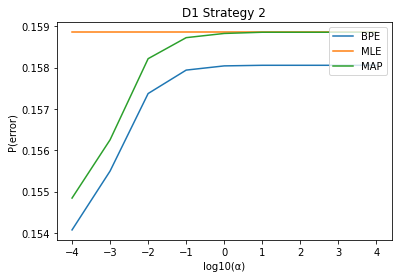

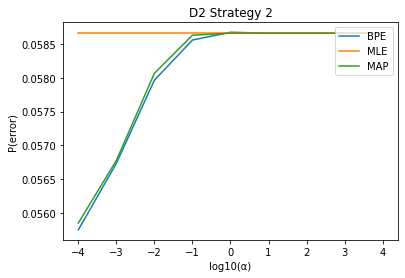

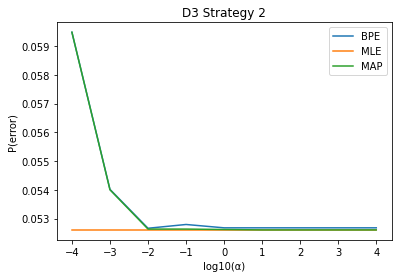

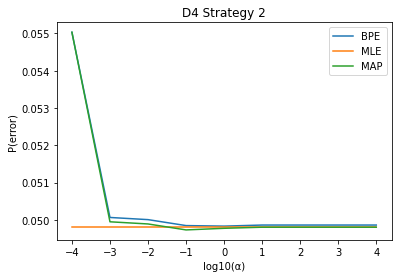

In [32]:
for i in range(dataset_num):
    plt.plot(alpha_log, BPE_error_p2[i], label='BPE')
    plt.plot(alpha_log, np.ones(9) * MLE_error_p2[i], label='MLE')
    plt.plot(alpha_log, MAP_error_p2[i], label='MAP')
    plt.title('D{} Strategy 2'.format(i+1))
    plt.legend(loc='upper right')
    plt.xlabel('log10(\u03B1)')
    plt.ylabel('P(error)')
    plt.show()

Because of the aforementioned reason, $\alpha$ does not influence Maximum Likelihood Estimate and therefore the results are the same for both strategy 1 and strategy 2. One interesting thing can be observed in strategy 2: the probability of error appears to be flipped vertically in dataset 1 & 2 relative to strategy 2, that is, the error for Bayesian Parameter Estimation and Maximum A Posteriori Estimation actually increases as $\alpha$ increases. While the orientation of the graph does not change for datasets 3 & 4, we can also observe that the Bayesian Parameter Estimation and Maximum A Posteriori Estimation are much closely aligned with each other using strategy 2. We can also note that similarly, Bayesian Parameter Estimation performs better relative to the other two methods when using a smaller dataset, again proving the significance of prior belief the the sample is small. Strategy 1 and strategy 2 are different in their prior mean: in strategy 1, $\mu_0=1$ for FG & $\mu_0=3$ for BG and in strategy 2, $\mu_0=2$ for both classes. With a smaller dataset ($D_{1}$ & $D_{2}$) and smaller $\alpha$ value ($log_{10}\alpha < 0$), the probability of error for strategy 2 is actually lower for both Bayesian Parameter Estimation and Maximum A Posteriori Estimation compared to the Maximum Likehihood Estimation because $\mu_0$ weighs more than $\hat{\mu}$ in this situation. On the other hand, with larger dataset ($D_{3}$ & $D_{4}$) and largerer $\alpha$ value ($log_{10}\alpha > 0$), the result for both strategies follows the same trend because $\hat{\mu}$ weighs more than $\mu_0$ and therefore $\mu_0$ has less influence. The fact that $\mu_0=2$ for both classes for strategy 2 also causes the result of Bayesian Parameter Estimation and Maximum A Posteriori Estimation to be more closely aligned in strategy 2 than strategy 1. 
